Authors: A.Radhakrishnan, GFDL
Ack: Anderson Banihirwe for intake-esm updates, GFDL colleagues for data

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
import numpy as np
%matplotlib inline

In [2]:
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()
cluster

Scale adaptively or manually as needed if you don't have ipywidgets


In [10]:
cluster

Use the following to list clusters and connect to it should one be open.


Alternate way to create cluster is found below

Connect your client to cluster

In [6]:
from distributed import Client

client = Client(cluster)
client


Client Scheduler: gateway://traefik-hub-dask-gateway.hub:80/hub.88a4b2dfde1a4ae08a53370b9994beeb Dashboard: /services/dask-gateway/clusters/hub.88a4b2dfde1a4ae08a53370b9994beeb/status,Cluster Workers: 2 Cores: 2 Memory: 4.29 GB


What options could I tweak 

In [8]:
options = gateway.cluster_options()  
options

esgf-world.json is the ESM collections spec file for the netCDF data in the S3 bucket esgf-world. 
The catalog is updated on an on-demand basis for now. 
You can refer to https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/esm-collection-spec-examples for the most recent catalogs
More examples can be found in https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/examples 


In [11]:
col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
#col_url = "https://raw.githubusercontent.com/aradhakrishnanGFDL/gfdl-aws-analysis/community/esm-collection-spec-examples/esgf-world.json"

In [12]:
col = intake.open_esm_datastore(col_url)

In [13]:
col.df

,project,institute,model,experiment_id,frequency,modeling_realm,mip_table,ensemble_member,grid_label,variable,temporal subset,version,path
0,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,NaN,NaN,AERmon,r1i1p1f1,gn,ps,185001-201412,v20200318,s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...
1,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,NaN,NaN,CFmon,r1i1p1f1,gn,ta,185001-201412,v20200318,s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...
2,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,NaN,NaN,Lmon,r1i1p1f1,gn,rh,185002-201412,v20200318,s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...
3,CMIP6,AS-RCEC,TaiESM1,histSST,NaN,NaN,AERmon,r1i1p1f1,gn,ps,185001-201412,v20200310,s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...
4,CMIP6,AS-RCEC,TaiESM1,histSST,NaN,NaN,CFmon,r1i1p1f1,gn,ta,185001-201412,v20200316,s3://esgf-world/CMIP6/AerChemMIP/AS-RCEC/TaiES...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
424087,CMIP6,THU,CIESM,ssp585,mon,atmos,Amon,r1i1p1f1,gr,rlds,201501-210012,v20200417,s3://esgf-world/CMIP6/ScenarioMIP/THU/CIESM/ss...
424088,CMIP6,THU,CIESM,ssp585,mon,atmos,Amon,r1i1p1f1,gr,rsds,201501-210012,v20200417,s3://esgf-world/CMIP6/ScenarioMIP/THU/CIESM/ss...
424089,CMIP6,THU,CIESM,ssp585,mon,atmos,Amon,r1i1p1f1,gr,ta,201501-210012,v20200417,s3://esgf-world/CMIP6/ScenarioMIP/THU/CIESM/ss...
424090,CMIP6,THU,CIESM,ssp585,mon,ocean,Omon,r1i1p1f1,gn,thetao,201501-206412,v20200220,s3://esgf-world/CMIP6/ScenarioMIP/THU/CIESM/ss...


In [14]:
#Examples to just search for what we want from the catalog
expname_filter = ['historical']
table_id_filter = 'Amon'
model_filter = 'GFDL-ESM4'
variable_id_filter = "ta"
ens_filter = "r1i1p1f1"
version_filter = "v20190726"
grid_label = "gr1"
cat = col.search(experiment_id=expname_filter, mip_table=table_id_filter,model=model_filter,variable=variable_id_filter,version="v20190726")

In [18]:
cat #this intake_esm.core.esm_datastore tells us there are 2 matching files/assets

,unique
project,1
institute,1
model,1
experiment_id,1
frequency,1
modeling_realm,1
mip_table,1
ensemble_member,1
grid_label,1
variable,1


Convert esm datastore to a dictionary so we can start using it

In [19]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 1}},storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [21]:
dset_dict.keys() #since we already applied a search, this only has one unique dataset, works for us

dict_keys(['CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Amon'])

In [24]:
hxr_gfdl_esm4 = dset_dict["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Amon"]#the values are xarray dataset objects

In [25]:
hxr_gfdl_esm4  #this is an xarray dataset. 

,Array,Chunk
Bytes,7.80 GB,3.94 MB
Shape,"(1, 1980, 19, 180, 288)","(1, 1, 19, 180, 288)"
Count,5942 Tasks,1980 Chunks
Type,float32,numpy.ndarray


In [28]:
hxr_gfdl_esm4.plev

<xarray.DataArray 'plev' (plev: 19)>
array([100000.,  92500.,  85000.,  70000.,  60000.,  50000.,  40000.,  30000.,
        25000.,  20000.,  15000.,  10000.,   7000.,   5000.,   3000.,   2000.,
         1000.,    500.,    100.])
Coordinates:
  * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
Attributes:
    long_name:      pressure
    units:          Pa
    axis:           Z
    positive:       down
    standard_name:  air_pressure
    description:    There are 19  requested levels. If the upper levels are a...

! GLOBAL MEAN 
let hgtas = tas[x=@ave,y=@ave,d=1,l=529:780@ave]


In [37]:
t=hxr_gfdl_esm4.ta.isel(plev=1) #lets select one of the levels, there is a total of 18 pressure levels here

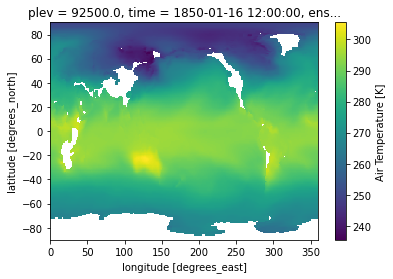

In [43]:
t.sel(time='1850-01').squeeze().plot()

In [48]:
#Examples to just search for what we want from the catalog
expname_filter = ['historical']
table_id_filter = 'fx'
model_filter = 'GFDL-ESM4'
variable_id_filter = "areacella"
ens_filter = "r1i1p1f1"
version_filter = "v20190726"
grid_label = "gr1"
cat_areacella = col.search(experiment_id=expname_filter, mip_table=table_id_filter,model=model_filter,variable=variable_id_filter,version="v20190726")

In [51]:
dset_dict_fx = cat_areacella.to_dataset_dict(storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [52]:
fx = dset_dict_fx["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.fx"]

In [53]:
fx

<xarray.Dataset>
Dimensions:          (ensemble_member: 1, lat: 180, lon: 288)
Coordinates:
  * lat              (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Data variables:
    areacella        (ensemble_member, lat, lon) float32 dask.array<chunksize=(1, 180, 288), meta=np.ndarray>
Attributes:
    history:                 File was processed by fremetar (GFDL analog of C...
    table_id:                fx
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    [0.]
    branch_time_in_parent:   [36500.]
    comment:                 <null ref>
    contact:                 gfdl.climate.model.info@noaa.gov
    Conventions:             CF-1.7 CMIP-6.0 UGRID-1.0
    creation_date:           2019-08-03T00:06:06Z
    data_specs_version:      01.00.27
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    forcing_index:           [1]
    frequency:               fx
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.G...
    grid:                    atmos data regridded from Cubed-sphere (c96) to ...
    grid_label:              gr1
    initialization_index:    [1]
    institution:             National Oceanic and Atmospheric Administration,...
    institution_id:          NOAA-GFDL
    license:                 CMIP6 model data produced by NOAA-GFDL is licens...
    mip_era:                 CMIP6
    nominal_resolution:      100 km
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_mip_era:          CMIP6
    parent_source_id:        GFDL-ESM4
    parent_time_units:       days since 0001-1-1
    parent_variant_label:    r1i1p1f1
    physics_index:           [1]
    product:                 model-output
    realization_index:       [1]
    realm:                   atmos land
    source:                  GFDL-ESM4 (2018):\natmos: GFDL-AM4.1 (Cubed-sphe...
    source_id:               GFDL-ESM4
    source_type:             AOGCM AER CHEM BGC
    sub_experiment:          none
    sub_experiment_id:       none
    title:                   NOAA GFDL GFDL-ESM4 model output prepared for CM...
    tracking_id:             hdl:21.14100/0972f78b-158e-4c6b-bcdf-7d0d75d7a8cd
    variable_id:             areacella
    variant_info:            N/A
    references:              see further_info_url attribute
    variant_label:           r1i1p1f1
    intake_esm_varname:      ['areacella']
    intake_esm_dataset_key:  CMIP6.NOAA-GFDL.GFDL-ESM4.historical.fx

In [59]:
total_area = fx.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (hxr_gfdl_esm4.ta * fx.areacella).sum(dim=['lon', 'lat']) / total_area
ta_timeseries

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1367: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


<xarray.DataArray (ensemble_member: 1, time: 1980, plev: 19)>
dask.array<truediv, shape=(1, 1980, 19), dtype=float32, chunksize=(1, 1, 19), chunktype=numpy.ndarray>
Coordinates:
  * plev             (plev) float64 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * time             (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [73]:
%time ta_timeseries.isel(plev=1).load()

CPU times: user 270 µs, sys: 18 µs, total: 288 µs
Wall time: 291 µs


<xarray.DataArray (ensemble_member: 1, time: 1980)>
array([[206.31187, 206.59924, 206.875  , ..., 208.13625, 207.19461,
        206.93034]], dtype=float32)
Coordinates:
    plev             float64 9.25e+04
  * time             (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

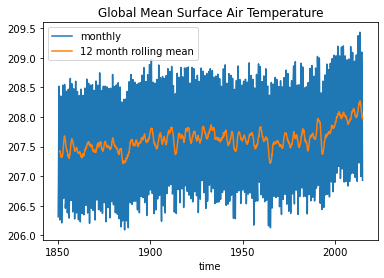

In [65]:
ta_timeseries.isel(plev=1).plot(label='monthly')
ta_timeseries.isel(plev=1).rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')

In [ ]:
cluster.close()
client.close()

In [66]:
cluster

In [67]:
fx.areacella

<xarray.DataArray 'areacella' (ensemble_member: 1, lat: 180, lon: 288)>
dask.array<broadcast_to, shape=(1, 180, 288), dtype=float32, chunksize=(1, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat              (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Attributes:
    long_name:      Grid-Cell Area for Atmospheric Variables
    units:          m2
    standard_name:  cell_area
    cell_methods:   area: sum
    interp_method:  conserve_order1
    original_name:  areacella

In [72]:
hxr_gfdl_esm4.ta

,Array,Chunk
Bytes,7.80 GB,3.94 MB
Shape,"(1, 1980, 19, 180, 288)","(1, 1, 19, 180, 288)"
Count,5942 Tasks,1980 Chunks
Type,float32,numpy.ndarray


In [ ]:
cluster.close()
client.close()